In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
navoneel_brain_mri_images_for_brain_tumor_detection_path = kagglehub.dataset_download('bhaveshmittal/melanoma-cancer-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'melanoma-cancer-dataset' dataset.
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#dataset loading

In [ ]:
import os
import pandas as pd
import numpy as np


from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
OD = OrdinalEncoder(categories= [['Benign', 'Malignant']])
LABEL = ['Benign', 'Malignant']

In [ ]:
x_train = pd.read_csv('/content/melanoma-cancer-dataset_x_train.csv')
y_train = pd.read_csv('/content/melanoma-cancer-dataset_y_train.csv')

x_val = pd.read_csv('/content/melanoma-cancer-dataset_x_val.csv')
y_val = pd.read_csv('/content/melanoma-cancer-dataset_y_val.csv')

x_test = pd.read_csv('/content/melanoma-cancer-dataset_x_test.csv')
y_test = pd.read_csv('/content/melanoma-cancer-dataset_y_test.csv')

In [ ]:
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


x_val = x_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
print(y_train.value_counts())
needed = 3418 - 1266
print('___________')
print(needed)

label    
Benign       5831
Malignant    1600
Name: count, dtype: int64
___________
2152


In [ ]:
def images_show(index_list, x, y):
    x_col = x.iloc[:, 0] if hasattr(x, "iloc") else x
    y_col = y.iloc[:, 0] if hasattr(y, "iloc") else y

    images = []
    for idx in index_list:
        img_path = x_col.iloc[idx] if hasattr(x_col, "iloc") else x_col[idx]
        image = load_img(img_path, target_size=(150,150))
        images.append(image)

    plt.figure(figsize=(60, 45))
    for j, im in enumerate(images):
        idx = index_list[j]
        label = y_col.iloc[idx] if hasattr(y_col, "iloc") else y_col[idx]
        plt.subplot(5, 5, j+1)
        plt.imshow(im)
        plt.title(f"{idx} : {label}", fontsize=60)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


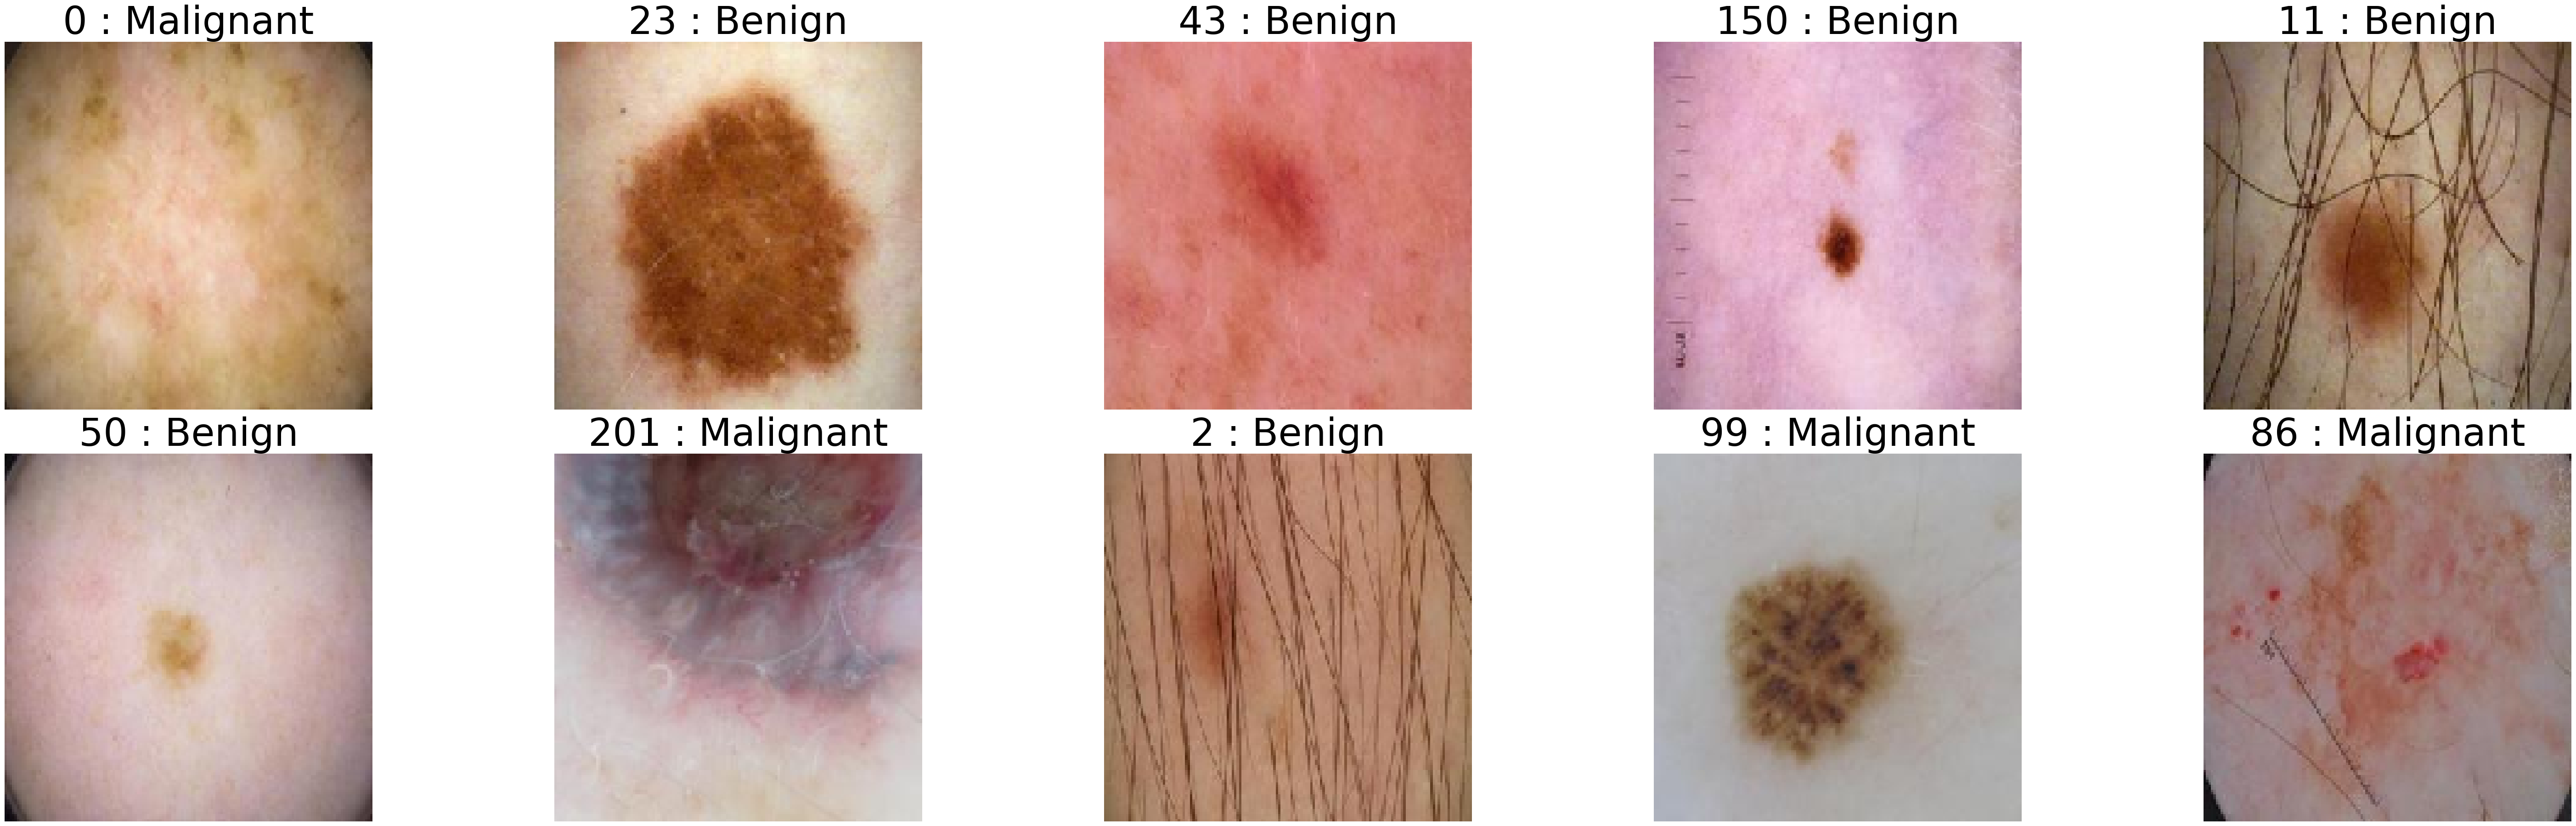

In [ ]:
# showing a sample from x_train ,any number between 0 - 201
images_show(index_list=[0, 23, 43, 150,
            11, 50,  201, 2, 99, 86], x=x_train, y=y_train)

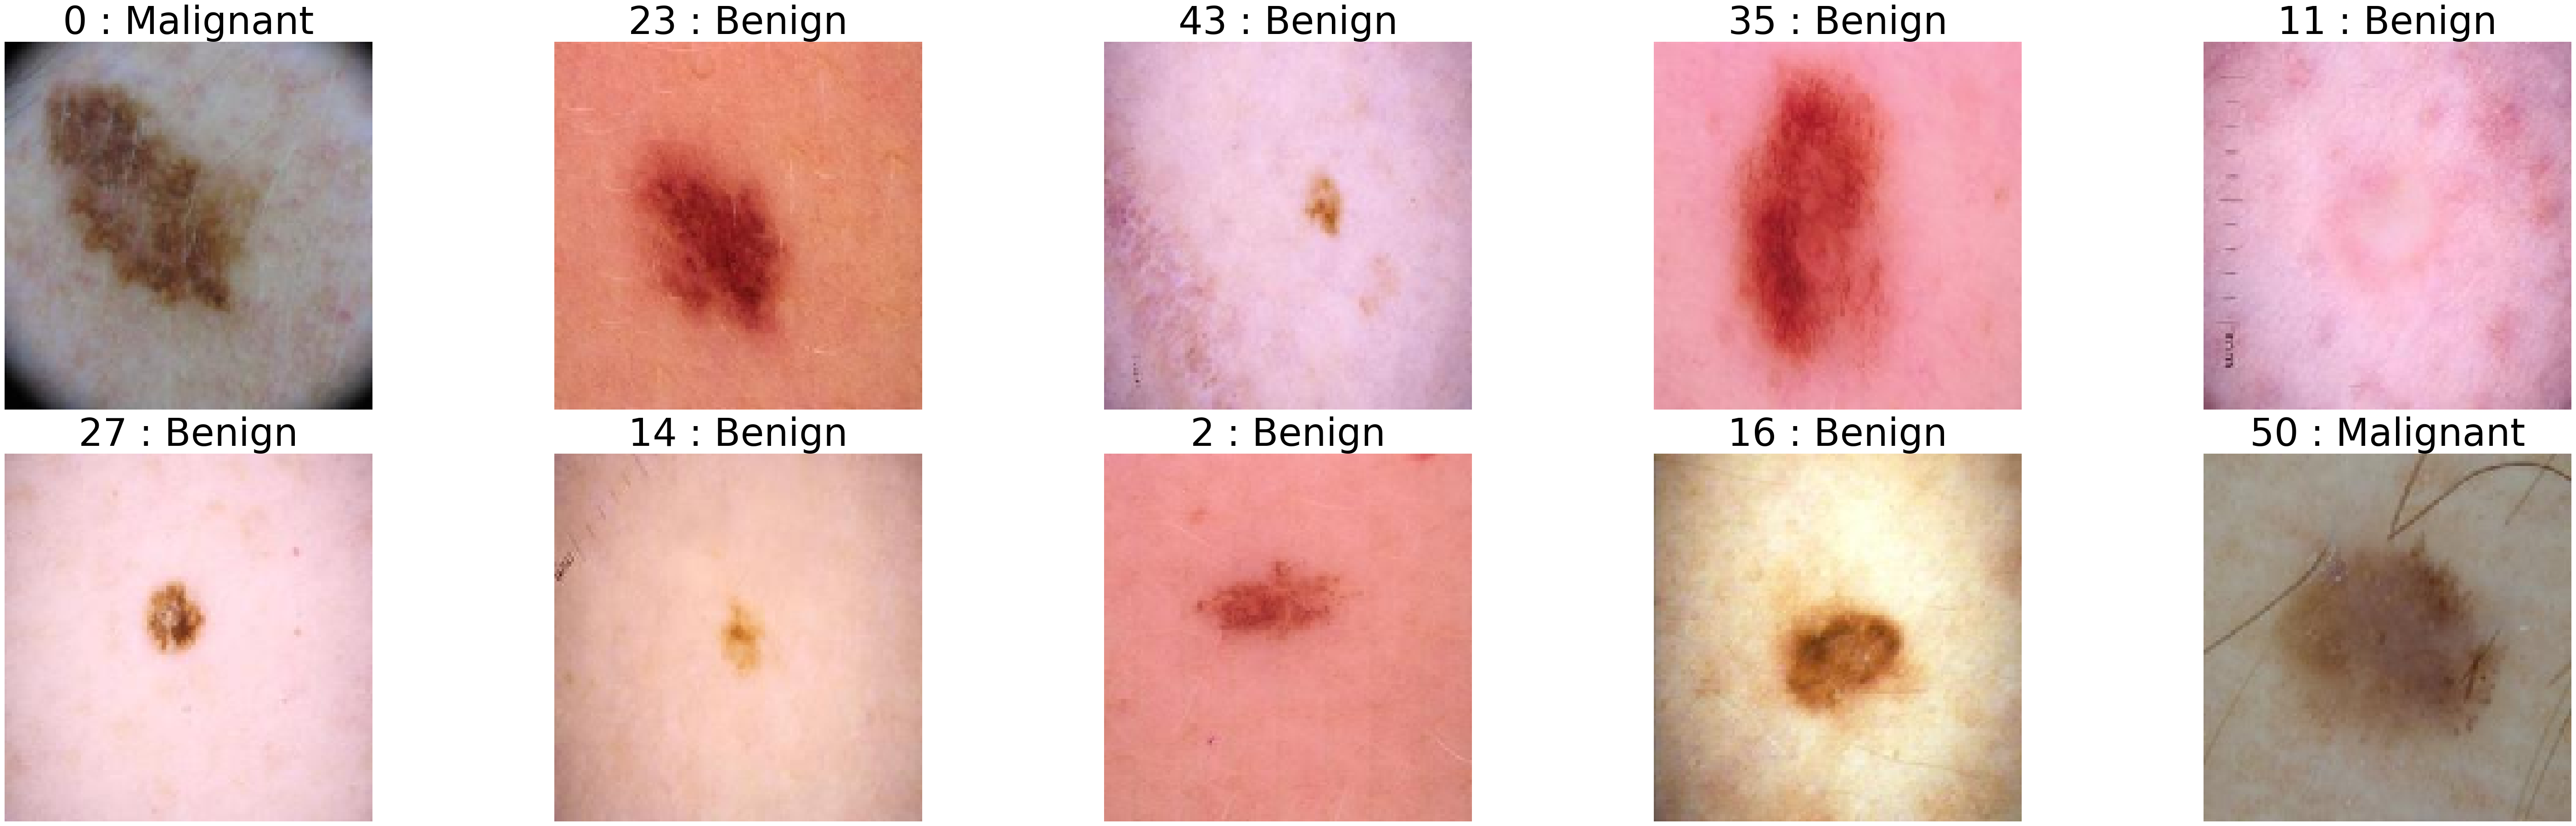

In [ ]:
# showing a sample from x_test ,any number between 0 - 50
images_show(index_list=[0, 23, 43, 35,
            11, 27,  14, 2, 16, 50], x=x_test, y=y_test)

In [ ]:
import numpy as np
import os
from tensorflow.keras.utils import load_img, img_to_array

def Array_con(df, target_size=(64,64)):
    paths = df["path"].astype(str).tolist()

    arr = []
    missing = []
    for p in paths:
        if not os.path.exists(p):
            missing.append(p)
            continue
        img = load_img(p, target_size=target_size)
        arr.append(img_to_array(img))

    if len(arr) == 0:
        print("Example missing path:", missing[0] if missing else "None")
        raise ValueError("No images loaded. Your paths don't exist in this runtime.")

    print(f"Loaded {len(arr)} images, skipped {len(missing)} missing.")
    return np.array(arr, dtype=np.float32)


In [ ]:
x_train = Array_con(x_train)
x_val = Array_con(x_val)
x_test = Array_con(x_test)

Loaded 7431 images, skipped 0 missing.
Loaded 4644 images, skipped 0 missing.
Loaded 4645 images, skipped 0 missing.


In [ ]:
x_train.shape

(7431, 64, 64, 3)

In [ ]:
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
y_test

,label
0,Malignant
1,Benign
2,Benign
3,Malignant
4,Benign
...,...
4640,Benign
4641,Benign
4642,Benign
4643,Benign


In [ ]:
# applying "OD"

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)


y_train = OD.fit_transform(y_train)
y_test = OD.transform(y_test)

# CGAN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
n_classes = 2
latent_dim = 32
batch_size = 128
epochs = 20
print_every = 200

In [ ]:
x_train = np.asarray(x_train)
if x_train.dtype != np.float32:
    x_train = x_train.astype(np.float32)

if x_train.max() > 1.5:  # likely 0..255
    x_train = x_train / 255.0
x_train = (x_train * 2.0) - 1.0

In [ ]:
img_shape = x_train.shape[1:]                 # (64,64,3)
n_features = int(np.prod(img_shape))          # 12288
X_train_gan = x_train.reshape(len(x_train), n_features).astype(np.float32)

In [ ]:
# labels -> one-hot
y_train_np = np.asarray(y_train).reshape(-1).astype(int)
y_train_oh = tf.one_hot(y_train_np, depth=n_classes)

ds = tf.data.Dataset.from_tensor_slices((X_train_gan, y_train_oh))
ds = ds.shuffle(buffer_size=len(X_train_gan)).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
print("X_train_gan:", X_train_gan.shape, "n_features:", n_features)
print("y_train_oh:", y_train_oh.shape)

X_train_gan: (7431, 12288) n_features: 12288
y_train_oh: (7431, 2)


In [ ]:

def build_generator(latent_dim, n_classes, n_features):
    z_in = layers.Input(shape=(latent_dim,), name="z")
    y_in = layers.Input(shape=(n_classes,), name="y_onehot")

    x = layers.Concatenate()([z_in, y_in])
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(0.2)(x)
    out = layers.Dense(n_features, activation="tanh")(x)  # outputs in [-1, 1] approx

    return keras.Model([z_in, y_in], out, name="Generator")

def build_discriminator(n_features, n_classes):
    x_in = layers.Input(shape=(n_features,), name="x")
    y_in = layers.Input(shape=(n_classes,), name="y_onehot")

    x = layers.Concatenate()([x_in, y_in])
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model([x_in, y_in], out, name="Discriminator")

In [ ]:
G = build_generator(latent_dim, n_classes, n_features)
D = build_discriminator(n_features, n_classes)

bce = keras.losses.BinaryCrossentropy(from_logits=False)

d_opt = keras.optimizers.Adam(2e-4, beta_1=0.5)
g_opt = keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def train_step(real_x, real_y):
    bs = tf.shape(real_x)[0]

    # 1) Train Discriminator
    z = tf.random.normal((bs, latent_dim))
    fake_x = G([z, real_y], training=True)

    real_labels = tf.ones((bs, 1))
    fake_labels = tf.zeros((bs, 1))

    with tf.GradientTape() as tape_d:
        pred_real = D([real_x, real_y], training=True)
        pred_fake = D([fake_x, real_y], training=True)

        d_loss_real = bce(real_labels, pred_real)
        d_loss_fake = bce(fake_labels, pred_fake)
        d_loss = d_loss_real + d_loss_fake

    grads_d = tape_d.gradient(d_loss, D.trainable_variables)
    d_opt.apply_gradients(zip(grads_d, D.trainable_variables))

    # 2) Train Generator (try to fool D)
    z2 = tf.random.normal((bs, latent_dim))
    with tf.GradientTape() as tape_g:
        gen_x = G([z2, real_y], training=True)
        pred = D([gen_x, real_y], training=False)
        g_loss = bce(real_labels, pred)

    grads_g = tape_g.gradient(g_loss, G.trainable_variables)
    g_opt.apply_gradients(zip(grads_g, G.trainable_variables))

    return d_loss, g_loss

In [ ]:
for epoch in range(1, epochs + 1):
    d_losses, g_losses = [], []
    for real_x, real_y in ds:
        d_loss, g_loss = train_step(real_x, real_y)
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    if epoch % print_every == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs} | D loss: {tf.reduce_mean(d_losses):.4f} | G loss: {tf.reduce_mean(g_losses):.4f}")


Epoch 1/20 | D loss: 0.8728 | G loss: 0.8923


In [ ]:
def sample_images(n=8, class_id=1):
    z = tf.random.normal((n, latent_dim))
    y = tf.one_hot([class_id]*n, depth=n_classes)
    fake = G([z, y], training=False).numpy()          # (n, 12288)
    fake = fake.reshape(n, *img_shape)               # (n,64,64,3)
    fake = (fake + 1.0) / 2.0                        # back to [0,1] for display
    return np.clip(fake, 0, 1)

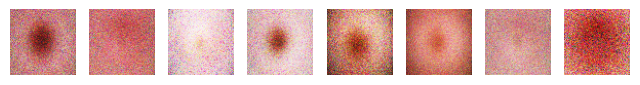

In [ ]:
imgs = sample_images(n=8, class_id=1)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,2))
for i in range(8):
     plt.subplot(1,8,i+1); plt.imshow(imgs[i]); plt.axis("off")
plt.show()

## Generate new data

In [ ]:
# y_train_np must be 1D ints
y_train_np = np.asarray(y_train_np).reshape(-1).astype(int)

counts = np.bincount(y_train_np)
minority = np.argmin(counts)
majority = np.argmax(counts)

need = counts[majority] - counts[minority]
print("Minority class:", minority, "| Need synthetic:", need)

# IMPORTANT: x_train must be flattened here (N, 12288)
# If your x_train is still images (N,64,64,3), flatten it:
if len(x_train.shape) == 4:
    x_train_flat = x_train.reshape(len(x_train), -1).astype(np.float32)
else:
    x_train_flat = x_train.astype(np.float32)

if need > 0:
    z = tf.random.normal((need, latent_dim))
    y_syn = tf.one_hot([minority] * need, depth=n_classes)
    x_syn = G([z, y_syn], training=False).numpy()   # (need, 12288) in [-1,1]

    # If you trained GAN with tanh and real data normalized to [-1,1],
    # then x_syn is already in the same GAN space as x_train_flat.
    # So DO NOT multiply by 3 unless your pipeline really used /3 clipping.
    # Use this only if your real training vectors were built as clip(X,-3,3)/3.
    x_syn_scaled = x_syn * 3.0  # keep ONLY if your real X_train_gan used /3 trick

    X_train_bal = np.vstack([x_train_flat, x_syn_scaled])
    y_train_bal = np.concatenate([y_train_np, np.full(need, minority, dtype=int)])
else:
    X_train_bal = x_train_flat
    y_train_bal = y_train_np

print("Balanced train counts:", np.bincount(y_train_bal))
print("X_train_bal shape:", X_train_bal.shape)


Minority class: 1 | Need synthetic: 4231
Balanced train counts: [5831 5831]
X_train_bal shape: (11662, 12288)


In [ ]:
# 1) reshape to images
X_train_bal = X_train_bal.reshape(-1, 64, 64, 3).astype(np.float32)

# 2) if GAN space was tanh [-1,1], convert to [0,1]
X_train_bal = (X_train_bal + 1.0) / 2.0
X_train_bal = np.clip(X_train_bal, 0.0, 1.0)

## Evaluating vanilla GAN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam , SGD, AdamW, Adadelta
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.regularizers import l2
import keras
from keras import ops

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
584/584 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.6276 - loss: 0.6145 - val_binary_accuracy: 0.7427 - val_loss: 0.6933
Epoch 2/60
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8498 - loss: 0.4492 - val_binary_accuracy: 0.7875 - val_loss: 0.6669
Epoch 3/60
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8720 - loss: 0.4290 - val_binary_accuracy: 0.8116 - val_loss: 0.6389
Epoch 4/60
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8783 - loss: 0.4160 - val_binary_accuracy: 0.8187 - val_loss: 0.6221
Epoch 5/60
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8881 - loss: 0.3997 - val_binary_accuracy: 0.8237 - val_loss: 0.6065
Epoch 6/60
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8886 - loss: 0.3918 - val_binary_accuracy: 0.8286 - val_loss: 0.5910
Epoch 7/60
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8879 - loss: 0.3793 - val_binary_accuracy: 0.8088 - val_loss: 0.4323
Epoch 

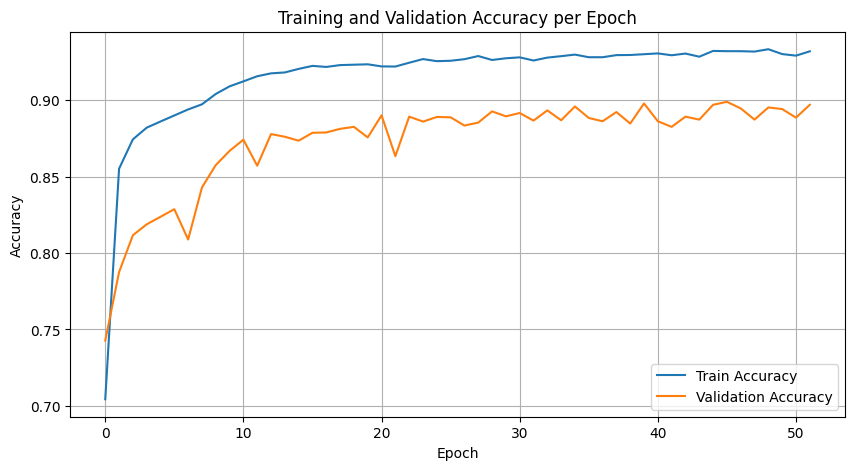

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93      3645
         1.0       0.80      0.68      0.74      1000

    accuracy                           0.89      4645
   macro avg       0.86      0.82      0.84      4645
weighted avg       0.89      0.89      0.89      4645


Confusion Matrix:


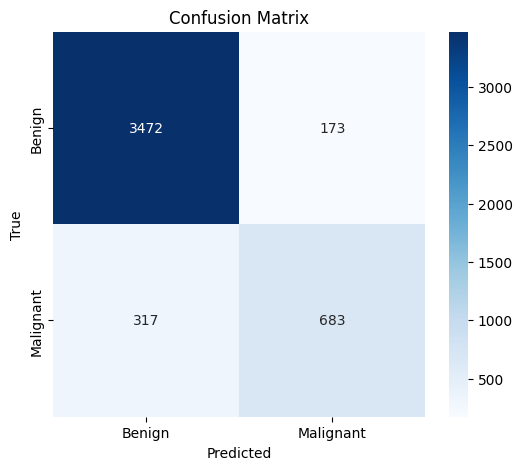

In [ ]:
model_cond_gan = models.Sequential([
    layers.Conv2D(16, (3, 3), strides=(1,1) ,activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPool2D(),
    layers.Conv2D(4, (3, 3), strides=(1,1) , activation='relu'),

    layers.Conv2D(4, (3, 3), strides=(1,1) , activation='relu'),
    layers.AveragePooling2D((1,1)),

    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])


model_cond_gan.compile(optimizer= Adam(learning_rate=0.0001),
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model_cond_gan.fit(X_train_bal, y_train_bal,
                    epochs=60,
                    batch_size=20,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping])


test_loss, test_accuracy = model_cond_gan.evaluate(x_test, y_test)
final_train_acc = history.history['binary_accuracy'][-1]

print(f"\nFinal Train Accuracy: {final_train_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



plt.figure(figsize=(10, 5))
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()




# Predict on test data
y_prob = model_cond_gan.predict(x_test).ravel()      # probabilities in [0,1]
y_pred = (y_prob >= 0.5).astype(int)        # class 0/1


# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix plot
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL, yticklabels=LABEL)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()